# Introduction


https://aclanthology.org/C18-1113.pdf

In [ ]:
!pip3 install numpy==1.24.4 \
                pandas==2.0.3 \
                camel-tools==1.5.2 \
                matplotlib==3.7.3 \
                nltk==3.8.1 \
                scikit-learn==1.3.2 \
                keras==2.11.0 \
                tensorflow==2.11.0 \
                gensim==4.3.2

## Imports

In [25]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
except ModuleNotFoundError:
    pass

import os
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.arlstem import ARLSTem
from camel_tools.tokenizers.word import simple_word_tokenize

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

import json
import requests
import unicodedata

import gensim
import keras.preprocessing as kpp
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import pad_sequences
from IPython.display import clear_output
from keras.callbacks import Callback


# import gc
# import json
# import tensorflow as tf
# from official.nlp.bert.tokenization import FullTokenizer
# from official.nlp.bert import tokenization
# from official.nlp.bert.bert_models import classifier_model as BertClassifier
# from official.nlp.bert.configs import BertConfig
# from official.nlp.optimization import create_optimizer

In [2]:
DATA_FOLDER = os.path.join(os.getcwd(), "data")

MADAR_FOLDER = os.path.join(DATA_FOLDER, "MADAR-SHARED-TASK-final-release-25Jul2019")
CORPUS_FOLDER = os.path.join(MADAR_FOLDER, "MADAR-Shared-Task-Subtask-1")
TRAIN_TSV = os.path.join(CORPUS_FOLDER, "MADAR-Corpus-6-train.tsv")
DEV_TSV = os.path.join(CORPUS_FOLDER, "MADAR-Corpus-6-dev.tsv")

KEYWORDS_TRAIN_FILENAME = os.path.join(DATA_FOLDER, "keywords_train")
KEYWORDS_DEV_FILENAME = os.path.join(DATA_FOLDER, "keywords_dev")
LEMMAS_TRAIN_FILENAME = os.path.join(DATA_FOLDER, "lemmas_train")
LEMMAS_DEV_FILENAME = os.path.join(DATA_FOLDER, "lemmas_dev")

FARASA_JAR = os.path.join(os.getcwd(), "farasa", "FarasaSegmenterJar.jar")

DATA_TRAIN_PKL = os.path.join(DATA_FOLDER, "data_train.pkl")
DATA_DEV_PKL = os.path.join(DATA_FOLDER, "data_dev.pkl")

ARAVEC_FOLDER = os.path.join(DATA_FOLDER, "aravec")
TWEETS_SG_100 = os.path.join(ARAVEC_FOLDER, "tweets_sg_100", "tweets_sg_100")

# Column headers for DataFrame
H_LABELS = "labels"
H_PHRASES = "phrases"
H_TOKENS = "tokens"
H_KEYWORDS = "keywords"
H_STEMS = "stems"
H_LEMMAS = "lemmas"

# Data Preprocessing

https://camel.abudhabi.nyu.edu/madar-parallel-corpus/

Citing Guide - please follow the following citation guide if you use any of this work in your research:
Please cite the following if you use the "MADAR Corpus/Lexicon Dataset" in your research:

Bouamor, Houda, Nizar Habash, Mohammad Salameh, Wajdi Zaghouani, Owen Rambow, Dana Abdulrahim, Ossama Obeid, Salam Khalifa, Fadhl Eryani, Alexander Erdmann and Kemal Oflazer. The MADAR Arabic Dialect Corpus and Lexicon. In Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018), Miyazaki, Japan, 2018.

Please cite the following if you use the "MADAR Twitter Dataset" in your research:

Bouamor, Houda, Sabit Hassan, and Nizar Habash. The MADAR Shared Task on Arabic Fine-Grained Dialect Identification. In Proceedings of the Workshop for Arabic Natural Language Processing. Florence, Italy, 2019.

## Reading the data from file

<p>We read the data in as dataframes, with an <strong>X</strong> column containing string in Arabic, and a <strong>y</strong> column containing a dialect label.</p>

In [7]:
def read_tsv(path):
    df = pd.read_csv(path, sep="\t", names=[H_PHRASES, H_LABELS])
    return df[[H_LABELS, H_PHRASES]]


data_train = read_tsv(TRAIN_TSV)
data_dev = read_tsv(DEV_TSV)

print(data_train.head())

  labels                           phrases
0    RAB  شناهوا م تخصص هذا المطعم اليوم ؟
1    MSA                         جو لطيف .
2    BEI             انبسطت كتير بمعرفتك .
3    BEI  وايتر ، بتجيب الحساب إذا بتريد ؟
4    BEI                 إذا بتريد تركني .


In [8]:
def count_labels(train, dev):
    print("\tTrain\tDev")
    for label in train[H_LABELS].unique():
        train_count = len(train[train[H_LABELS] == label])  # Can't put dataframe slice in f string ?!
        dev_count = len(dev[dev[H_LABELS] == label])
        print(f"{label}\t{train_count}\t{dev_count}")
    print(f"\nTotal\t{len(train)}\t{len(dev)}")

count_labels(data_train, data_dev)

	Train	Dev
RAB	9000	1000
MSA	9000	1000
BEI	9000	1000
DOH	9000	1000
CAI	9000	1000
TUN	9000	1000

Total	54000	6000


## Tokenization
<p>CAMeL Tools can tokenize the sentences, which are put in a new column called <strong>tokens</strong>.</p>


In [9]:
for df in [data_train, data_dev]:
    df[H_TOKENS] = df[H_PHRASES].apply(lambda line: simple_word_tokenize(line))

print(data_train.head())

  labels                           phrases  \
0    RAB  شناهوا م تخصص هذا المطعم اليوم ؟   
1    MSA                         جو لطيف .   
2    BEI             انبسطت كتير بمعرفتك .   
3    BEI  وايتر ، بتجيب الحساب إذا بتريد ؟   
4    BEI                 إذا بتريد تركني .   

                                     tokens  
0  [شناهوا, م, تخصص, هذا, المطعم, اليوم, ؟]  
1                             [جو, لطيف, .]  
2                [انبسطت, كتير, بمعرفتك, .]  
3  [وايتر, ،, بتجيب, الحساب, إذا, بتريد, ؟]  
4                    [إذا, بتريد, تركني, .]  


## Removing non-Arabic characters
<p>Let's look at the tokenized data for uninteresting symbols. Below we see some punctuation which probably doesn't have anything useful to contribute.</p>

In [10]:
def is_arabic_char(char):

    arabic_range_start = 0x0600
    arabic_range_end = 0x06FF
    return (arabic_range_start <= ord(char) <= arabic_range_end) and unicodedata.category(char)[0] != "P"


def is_arabic_token(token):

    is_arabic = [is_arabic_char(c) for c in token]
    return sum(is_arabic) == len(is_arabic)


def get_length_n_words(token_column, n):

    n_tokens = [token for phrase in token_column for token in phrase if len(token) == n]
    return sorted(set(n_tokens))


def show_non_arabic(n, token_column):

    length_n_tokens = get_length_n_words(token_column, n)
    non_arabic = [token for token in length_n_tokens if not is_arabic_token(token)]
    print(f"n={n} ", non_arabic if len(non_arabic) > 0 else "All Arabic characters")

    return non_arabic


def check_arabic(all_tokens):

    token_lengths = [len(token) for phrase in all_tokens for token in phrase]
    longest_token = max(token_lengths)
    print("Longest Token:", longest_token)

    non_arabic = []
    for n in range(1, longest_token + 1):
        non_arabic += show_non_arabic(n, all_tokens)
    return non_arabic

In [11]:
non_arabic = check_arabic(pd.concat((data_train[H_TOKENS], data_dev[H_TOKENS])))

Longest Token: 17
n=1  ['!', '"', "'", '(', ')', ',', '-', '.', '5', '6', ':', '<', '،', '؛', '؟', '“', '”']
n=2  ['30']
n=3  All Arabic characters
n=4  All Arabic characters
n=5  All Arabic characters
n=6  All Arabic characters
n=7  All Arabic characters
n=8  All Arabic characters
n=9  All Arabic characters
n=10  All Arabic characters
n=11  All Arabic characters
n=12  All Arabic characters
n=13  All Arabic characters
n=14  All Arabic characters
n=15  All Arabic characters
n=16  All Arabic characters
n=17  All Arabic characters


In [12]:
for df in [data_train, data_dev]:
    df[H_TOKENS] = df[H_TOKENS].apply(lambda token_list: [token for token in token_list if token not in non_arabic])

_ = check_arabic(pd.concat((data_train[H_TOKENS], data_dev[H_TOKENS])))

Longest Token: 17
n=1  All Arabic characters
n=2  All Arabic characters
n=3  All Arabic characters
n=4  All Arabic characters
n=5  All Arabic characters
n=6  All Arabic characters
n=7  All Arabic characters
n=8  All Arabic characters
n=9  All Arabic characters
n=10  All Arabic characters
n=11  All Arabic characters
n=12  All Arabic characters
n=13  All Arabic characters
n=14  All Arabic characters
n=15  All Arabic characters
n=16  All Arabic characters
n=17  All Arabic characters


In [13]:
data_train.head()

,labels,phrases,tokens
0,RAB,شناهوا م تخصص هذا المطعم اليوم ؟,"[شناهوا, م, تخصص, هذا, المطعم, اليوم]"
1,MSA,جو لطيف .,"[جو, لطيف]"
2,BEI,انبسطت كتير بمعرفتك .,"[انبسطت, كتير, بمعرفتك]"
3,BEI,وايتر ، بتجيب الحساب إذا بتريد ؟,"[وايتر, بتجيب, الحساب, إذا, بتريد]"
4,BEI,إذا بتريد تركني .,"[إذا, بتريد, تركني]"


## Removing Stop Words
<p>Certain words don't add much meaning to a sentence and can be omitted. In English, these are words such as <strong>the</strong> or <strong>an</strong>. NLTK provides lists of such words for several languages, including Arabic.</p>
<p>In row 0, the word <strong>هناك</strong>, which means <strong>over there</strong>, has been removed.

In [14]:
# Uncomment the following line the first time the notebook is run
# nltk.download("stopwords")

arabic_stopwords = stopwords.words("arabic")

for df in [data_train, data_dev]:
    df[H_KEYWORDS] = df[H_TOKENS].apply(lambda tokens: [t for t in tokens if t not in arabic_stopwords])

data_train.head()

,labels,phrases,tokens,keywords
0,RAB,شناهوا م تخصص هذا المطعم اليوم ؟,"[شناهوا, م, تخصص, هذا, المطعم, اليوم]","[شناهوا, تخصص, المطعم, اليوم]"
1,MSA,جو لطيف .,"[جو, لطيف]","[جو, لطيف]"
2,BEI,انبسطت كتير بمعرفتك .,"[انبسطت, كتير, بمعرفتك]","[انبسطت, كتير, بمعرفتك]"
3,BEI,وايتر ، بتجيب الحساب إذا بتريد ؟,"[وايتر, بتجيب, الحساب, إذا, بتريد]","[وايتر, بتجيب, الحساب, بتريد]"
4,BEI,إذا بتريد تركني .,"[إذا, بتريد, تركني]","[بتريد, تركني]"


### Drop rows with empty unstopped lists

In [15]:
# Drop rows with empty token lists

for df in [data_train, data_dev]:
    df[H_KEYWORDS] = df[H_KEYWORDS].apply(lambda x: np.nan if len(x) == 0 else x)
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

count_labels(data_train, data_dev)

	Train	Dev
RAB	8990	998
MSA	8971	999
BEI	8989	1000
DOH	8985	999
CAI	8997	1000
TUN	8986	999

Total	53918	5995


## Truncating token lists

<p>Let's have a look at the lengths of the token lists. In the training set, the average string length is about 5, with the longest being 30.</p>

Average: 4.622834674876665


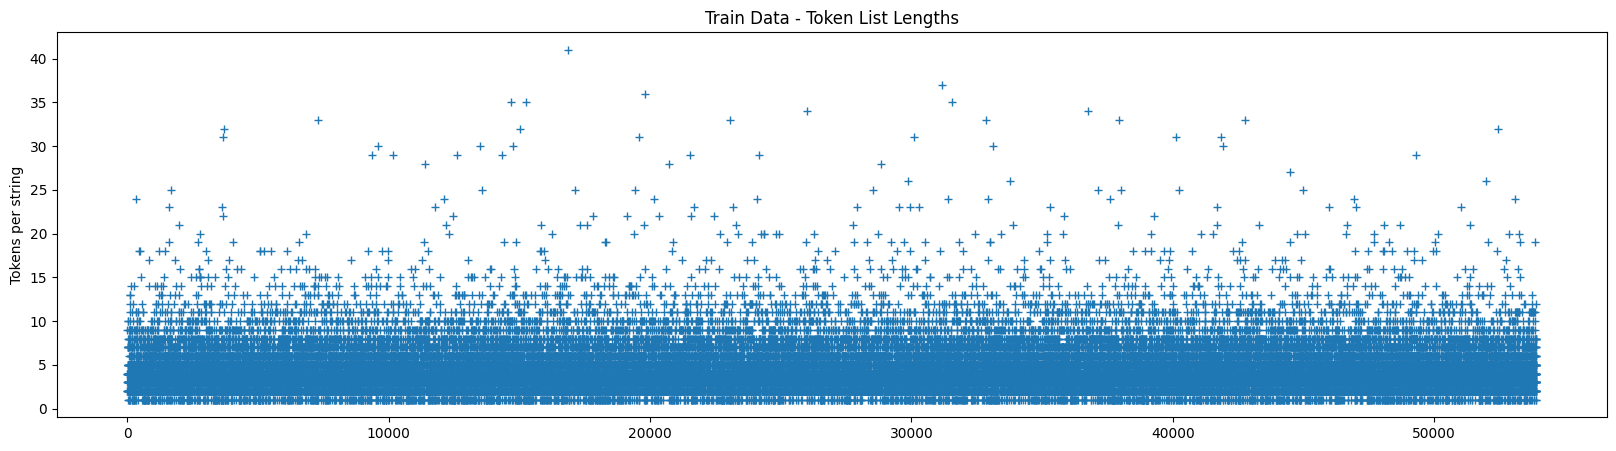

Average: 4.599666388657214


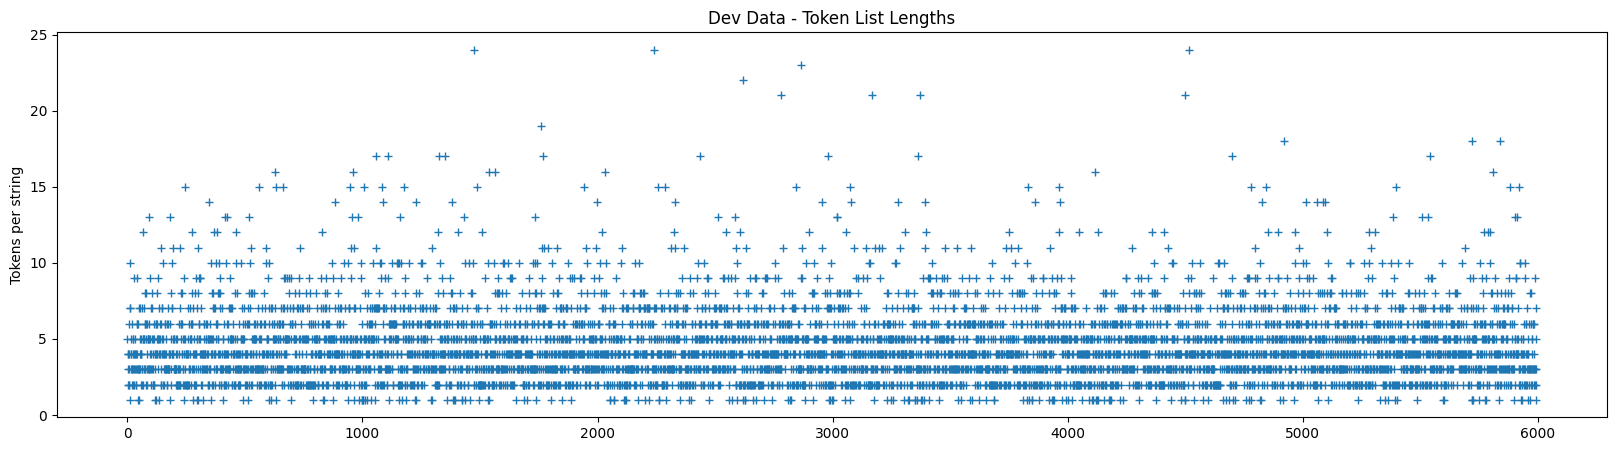

In [16]:
def plot_lengths(df, title):
  '''
  Plot the lengths of the sentences in the given dataframe
  '''
  lengths = [len(tokens) for tokens in df[H_KEYWORDS]]
  print("Average:", sum(lengths) / len(lengths))

  plt.figure(figsize=(20, 5))
  plt.plot(lengths, "+")
  plt.ylabel("Tokens per string")
  plt.title(title)
  plt.show()

plot_lengths(data_train, "Train Data - Token List Lengths")
plot_lengths(data_dev, "Dev Data - Token List Lengths")

Average: 4.448003468949135


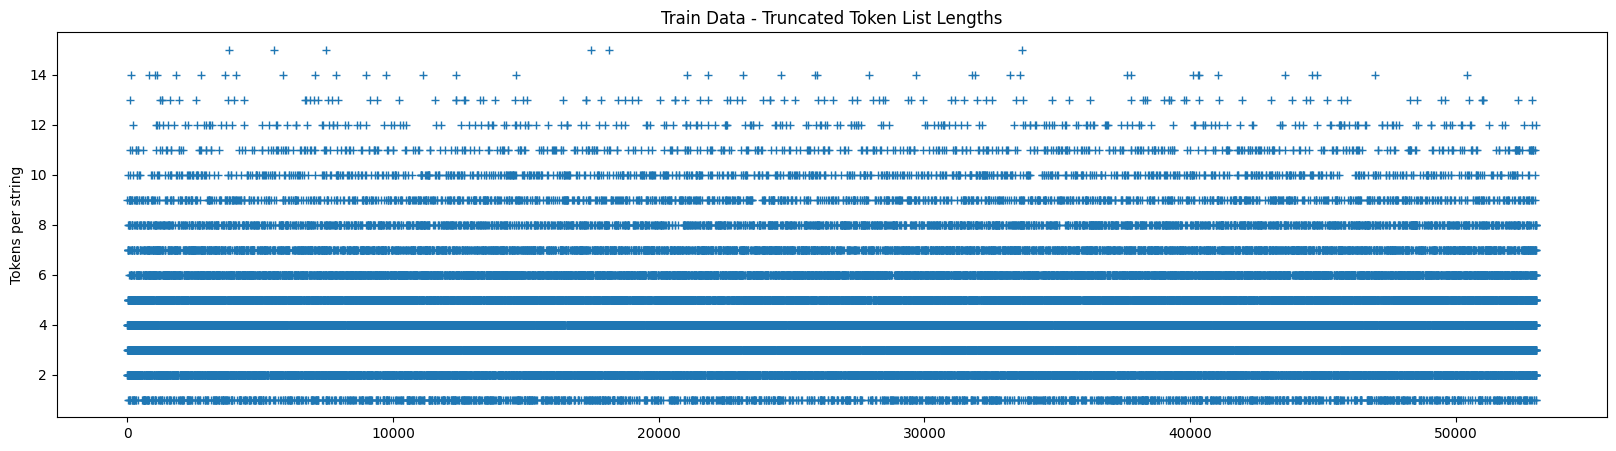

Average: 4.44634394041977


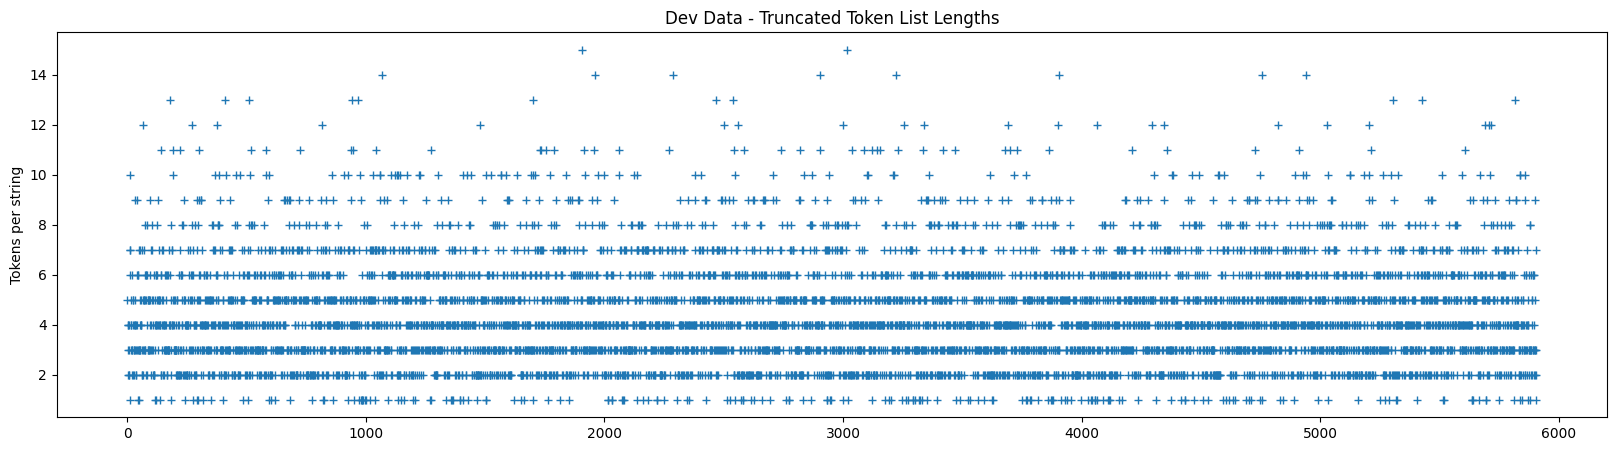

In [17]:
token_limit = 15

for df in [data_train, data_dev]:
  df[H_TOKENS] = df[H_TOKENS].apply(lambda token_list: token_list if len(token_list) <= token_limit else np.nan)
  df.dropna(axis=0, inplace=True)
  df.reset_index(drop=True, inplace=True)

plot_lengths(data_train, "Train Data - Truncated Token List Lengths")
plot_lengths(data_dev, "Dev Data - Truncated Token List Lengths")

In [18]:
count_labels(data_train, data_dev)

	Train	Dev
RAB	8836	982
MSA	8760	978
BEI	8882	988
DOH	8874	989
CAI	8838	984
TUN	8852	987

Total	53042	5908


## Lemmatization & Stemming

### Lemmatization

<p>
Lemmatization is the conversion of a word to its base word, allowing for context. This reduces the number of tokens that need to be processed without loss of linguistic information. As a simple example, in the phases "The rabbit eats grass" and "The rabbit is eating grass", <em>eats</em> and <em>eating</em> can both be converted to the lemma "eat". Lemmatization can also handle irregular forms, such as converting <em>made</em> to <em>make<em>.
</p>

<p>
The most important aspect of lemmatization is the preservation of contextual meaning. Take the phrases "NLP is the best" and "They bested their foe". Naively, we could convert both <em>best</em> and <em>bested</em> to the verb <em>best</em>. However, its obvious to a human reader that only <em>bested</em> is a verb, and <em>best</em> is the superlative adjective of <em>good</em>.
</p>

<p>
Arabic has complex morphology, making lemmatization a challenging task. Existing libraries, such as described in <a href="https://arxiv.org/abs/1710.06700">Build Fast and Accurate Lemmatization for Arabic</a> by Hamdy Mubarak, are mostly trained on Modern Standard Arabic because this tends to the language of literature, and therefore represents the majority of available Arabic texts. As such, this notebook foregoes lemmatization to avoid removing distinguishing information from the dialect examples. Instead, it uses the simpler, albeit more naive, technique of stemming.
</p>

In [19]:
def write_keywords(df, filename):
    joined_keywords = df[H_KEYWORDS].apply(lambda keywords: " ".join(keywords))
    joined_keywords.to_csv(filename, index=False, header=False)

write_keywords(data_train, KEYWORDS_TRAIN_FILENAME)
write_keywords(data_dev, KEYWORDS_DEV_FILENAME)

!head -n 5 {KEYWORDS_TRAIN_FILENAME}

شناهوا تخصص المطعم اليوم
جو لطيف
انبسطت كتير بمعرفتك
وايتر بتجيب الحساب بتريد
بتريد تركني


In [20]:
!java -jar {FARASA_JAR} --lemma true --input {KEYWORDS_TRAIN_FILENAME} --output {LEMMAS_TRAIN_FILENAME}
!java -jar {FARASA_JAR} --lemma true --input {KEYWORDS_DEV_FILENAME} --output {LEMMAS_DEV_FILENAME}

System ready!               
System ready!               


In [21]:
def read_lemmas(df, filename):
    lemmas = [lemma.strip() for lemma in open(filename, "r").readlines()]
    df[H_LEMMAS] = pd.Series(lemmas)


read_lemmas(data_train, LEMMAS_TRAIN_FILENAME)
read_lemmas(data_dev, LEMMAS_DEV_FILENAME)

data_train.head()

,labels,phrases,tokens,keywords,lemmas
0,RAB,شناهوا م تخصص هذا المطعم اليوم ؟,"[شناهوا, م, تخصص, هذا, المطعم, اليوم]","[شناهوا, تخصص, المطعم, اليوم]",شناهوا خصص مطعم يوم
1,MSA,جو لطيف .,"[جو, لطيف]","[جو, لطيف]",جو لطيف
2,BEI,انبسطت كتير بمعرفتك .,"[انبسطت, كتير, بمعرفتك]","[انبسطت, كتير, بمعرفتك]",انبسط كتير بمعرفتك
3,BEI,وايتر ، بتجيب الحساب إذا بتريد ؟,"[وايتر, بتجيب, الحساب, إذا, بتريد]","[وايتر, بتجيب, الحساب, بتريد]",ايتر أجاب حساب أراد
4,BEI,إذا بتريد تركني .,"[إذا, بتريد, تركني]","[بتريد, تركني]",أراد ترك


### Stemming

<p>
Stemming essentially truncates a word to its root. As discussed above, <em>eating</em> and <em>eats</em> can be lemmatized to <em>eat</em>. Likewise, they can both be stemmed to <em>eat</em>. However, while <em>made</em> can be lemmatized to <em>make</em>, it cannot be stemmed.
</p>

<p>As an example, the first word (from right to left) in the token list of row 0 has changed from <strong>تماما</strong> to <strong>تمام</strong>.</p>


In [22]:
# Create an Arabic stemmer from NLTK
stemmer = ARLSTem()

for df in [data_train, data_dev]:
    df[H_STEMS] = df[H_KEYWORDS].apply(lambda keywords: " ".join([stemmer.stem(t) for t in keywords]))

data_train.head()

,labels,phrases,tokens,keywords,lemmas,stems
0,RAB,شناهوا م تخصص هذا المطعم اليوم ؟,"[شناهوا, م, تخصص, هذا, المطعم, اليوم]","[شناهوا, تخصص, المطعم, اليوم]",شناهوا خصص مطعم يوم,شناه خصص مطعم يوم
1,MSA,جو لطيف .,"[جو, لطيف]","[جو, لطيف]",جو لطيف,جو لطيف
2,BEI,انبسطت كتير بمعرفتك .,"[انبسطت, كتير, بمعرفتك]","[انبسطت, كتير, بمعرفتك]",انبسط كتير بمعرفتك,انبسط كتير بمعرف
3,BEI,وايتر ، بتجيب الحساب إذا بتريد ؟,"[وايتر, بتجيب, الحساب, إذا, بتريد]","[وايتر, بتجيب, الحساب, بتريد]",ايتر أجاب حساب أراد,يتر بتجيب حساب بتريد
4,BEI,إذا بتريد تركني .,"[إذا, بتريد, تركني]","[بتريد, تركني]",أراد ترك,بتريد ركني


## Phrase -> Tokens -> Unstopped -> Lemmas/Stems

<p>
The row printed below shows the progression for the phrase <em>وايتر ، بتجيب الحساب إذا بتريد ؟</em> (Google Translate gives the translation <em>Waiter, can you get the account if you want?</em>). It's tokenized, then the stop word <em>إذا</em> (which roughly translates to <em>if</em>) is removed. Then lemmatization and stemming give slightly different results, as expected. The first words (fron right to left) are almost identical, differing from the original only a little, and both techniques have converted the third word in the same way. However, while the second and fourth words have been lemmatized, they have not been changed by stemming.
</p>

In [23]:
print(data_train.iloc[3])

labels                                     BEI
phrases       وايتر ، بتجيب الحساب إذا بتريد ؟
tokens      [وايتر, بتجيب, الحساب, إذا, بتريد]
keywords         [وايتر, بتجيب, الحساب, بتريد]
lemmas                     ايتر أجاب حساب أراد
stems                     يتر بتجيب حساب بتريد
Name: 3, dtype: object


## Label Balance
<p>It's good to be sure that there's a reasonable balance of each label in the training set. We see that each label occurs close to 6000 times (it was exactly 6000 until we dropped some rows), so there's no need to rebalance the data.</p> 


In [24]:
count_labels(data_train, data_dev)

	Train	Dev
RAB	8836	982
MSA	8760	978
BEI	8882	988
DOH	8874	989
CAI	8838	984
TUN	8852	987

Total	53042	5908


## Serialization

In [25]:
for df in [data_train, data_dev]:
    df.drop(columns=[H_PHRASES], inplace=True)
    for col in [H_TOKENS, H_KEYWORDS]:
        df[col] = df[col].apply(lambda token_list: " ".join(token_list))

data_train.head()

,labels,tokens,keywords,lemmas,stems
0,RAB,شناهوا م تخصص هذا المطعم اليوم,شناهوا تخصص المطعم اليوم,شناهوا خصص مطعم يوم,شناه خصص مطعم يوم
1,MSA,جو لطيف,جو لطيف,جو لطيف,جو لطيف
2,BEI,انبسطت كتير بمعرفتك,انبسطت كتير بمعرفتك,انبسط كتير بمعرفتك,انبسط كتير بمعرف
3,BEI,وايتر بتجيب الحساب إذا بتريد,وايتر بتجيب الحساب بتريد,ايتر أجاب حساب أراد,يتر بتجيب حساب بتريد
4,BEI,إذا بتريد تركني,بتريد تركني,أراد ترك,بتريد ركني


In [26]:
data_train.to_pickle(DATA_TRAIN_PKL)
data_dev.to_pickle(DATA_DEV_PKL)

# Classification

<p>Each model will split MADAR-Corpus-26-train into train/test sets at an 4:1 ratio, and later be evaluated on MADAR-Corpus-26-dev.</p>

<p><code>OneHotCodec</code> is a helper class which learns how to encode dialect labels (RAB, CAI, etc.) as onehot vectors, and to decode vectors back into labels.</p>

In [3]:
# Deserialize the data

data_train = pd.read_pickle(DATA_TRAIN_PKL)
data_dev = pd.read_pickle(DATA_DEV_PKL)

data_train.head()

,labels,tokens,keywords,lemmas,stems
0,RAB,شناهوا م تخصص هذا المطعم اليوم,شناهوا تخصص المطعم اليوم,شناهوا خصص مطعم يوم,شناه خصص مطعم يوم
1,MSA,جو لطيف,جو لطيف,جو لطيف,جو لطيف
2,BEI,انبسطت كتير بمعرفتك,انبسطت كتير بمعرفتك,انبسط كتير بمعرفتك,انبسط كتير بمعرف
3,BEI,وايتر بتجيب الحساب إذا بتريد,وايتر بتجيب الحساب بتريد,ايتر أجاب حساب أراد,يتر بتجيب حساب بتريد
4,BEI,إذا بتريد تركني,بتريد تركني,أراد ترك,بتريد ركني


## Scoring

In [28]:
def madar_score(gold_labels, predicted_labels, verbose=True):
    """
    Adapted from MADAR-DID-Scorer.py
    """
    if (verbose):
        labels = sorted(list(set(gold_labels)))
        accuracy = accuracy_score(gold_labels, predicted_labels) * 100 
        f1 = f1_score(gold_labels, predicted_labels, labels=labels, average=None) * 100
        recall = recall_score(gold_labels, predicted_labels, labels=labels, average = None) * 100
        precision = precision_score(gold_labels, predicted_labels, labels=labels, average=None) * 100

        print("\tPrecision\t\tRecall\t\t\tF1")
        for i, score in enumerate(labels):
            print(f"{labels[i]}\t{precision[i]}\t{recall[i]}\t{f1[i]}")
        print()

    accuracy = accuracy_score(gold_labels, predicted_labels) * 100
    f1 = f1_score(gold_labels, predicted_labels, average="macro") * 100
    recall = recall_score(gold_labels, predicted_labels, average="macro") * 100
    precision = precision_score(gold_labels, predicted_labels, average="macro") * 100

    print("Macro Averages")
    print(f"Precision\t{precision}")
    print(f"Recall\t\t{recall}")
    print(f"F1\t\t{f1}")
    print(f"Accuracy\t{accuracy}")

## Decision Tree Classifier

<p>
Term Frequency Inverse Document Frequency

<code>run_combos</code> generates a list of ngram_ranges, and trains a classifier on the <code>TfidfVectorizer</code> for each. The best model, as measured by accuracy on the test set, is returned for evaluation.
</p>

In [29]:
def run_combos(train_X, train_y, ngram_ranges):
    """
    Generate a list of ngram_ranges from lo/hi and train a DecisionTreeClassifier for each
    Return best performing classifier
    """
    best_score = 0
    best_classifier = None
    best_vectorizer = None

    for ngram_range in ngram_ranges:
        print(f"Training ngram_range: {ngram_range}", end="")

        vectorizer = TfidfVectorizer(ngram_range=ngram_range, analyzer="word")
        train_X_v = vectorizer.fit_transform(train_X)

        # Split the data into train/test
        train_X_n, test_X_n, train_y_n, test_y_n = train_test_split(train_X_v, train_y, shuffle=True, test_size=0.2, random_state=23)

        # Train the classifier
        classifier = DecisionTreeClassifier(random_state=23)
        classifier.fit(train_X_n, train_y_n)

        # Evaluate on the test set
        score = classifier.score(test_X_n, test_y_n)
        print(" -", score)
        if score > best_score:
            best_score = score
            best_classifier = classifier
            best_vectorizer = vectorizer

    return best_classifier, best_vectorizer

In [32]:
onehot_encoder = LabelBinarizer(sparse_output=False)
train_y = onehot_encoder.fit_transform(np.array(data_train[H_LABELS]).reshape(-1, 1))

ngram_ranges = [(1, 1), (1, 2), (1, 3)]

for col in [H_TOKENS, H_KEYWORDS]:#, H_STEMS, H_LEMMAS]:
    print(f"Evaluating {col}\n")
    best_classifier, best_vectorizer = run_combos(data_train[col], train_y, ngram_ranges)
    print(f"Best ngram range: {best_vectorizer.ngram_range}\n")

    vector_data = best_vectorizer.transform(data_dev[col])
    predictions = best_classifier.predict(vector_data)
    pred_labels = onehot_encoder.inverse_transform(predictions)
    madar_score(data_dev[H_LABELS], pred_labels)
    print("-" * 73)

Evaluating tokens

Training ngram_range: (1, 1) - 0.7375812988971628
Training ngram_range: (1, 2) - 0.7388066735790366
Training ngram_range: (1, 3) - 0.7450278065793194
Best ngram range: (1, 3)

	Precision		Recall			F1
BEI	60.798122065727696	78.64372469635627	68.57899382171227
CAI	76.65036674816625	63.71951219512195	69.58934517203107
DOH	58.45493562231759	68.85743174924166	63.23119777158773
MSA	85.01628664495115	80.06134969325154	82.46445497630333
RAB	84.70066518847007	77.80040733197556	81.104033970276
TUN	81.91747572815534	68.38905775075987	74.54445057979015

Macro Averages
Precision	74.58964199963135
Recall		72.91191390278448
F1		73.2520793819501
Accuracy	72.9011509817197
-------------------------------------------------------------------------
Evaluating keywords

Training ngram_range: (1, 1) - 0.7392779715336035
Training ngram_range: (1, 2) - 0.7376755584880762
Training ngram_range: (1, 3) - 0.7370157413516826
Best ngram range: (1, 1)

	Precision		Recall			F1
BEI	77.00534759358288	

## LSTM Deep Network

In [4]:
class ClearOutputCallback(Callback):
  """
  For LSTM and BERT
  Clear the output before each epoch to keep things tidy
  """
  def on_epoch_begin(self, epoch, logs=None):
    clear_output()


def plot_training(history):
  """
  Plot the training and validation loss/accuracy from history
  """
  x_ticks = range(1, len(history.history['acc']) + 1)
  plt.figure(figsize=(18, 6))

  # Loss
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(x_ticks, history.history['loss'], label='Training')
  plt.plot(x_ticks, history.history['val_loss'], label='Validation')
  plt.legend()

  # Accuracy
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.plot(x_ticks, history.history['acc'], label='Training')
  plt.plot(x_ticks, history.history['val_acc'], label='Validation')
  plt.legend()

  plt.show()

In [45]:
from tensorflow.keras.layers import Embedding

# https://github.com/piskvorky/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer


def build_lstm(aravec_model, num_classes):

  # Create a Sequential model
  model = Sequential()

  # Get the AraVec embedding layer with parameters frozen
  # model.add(aravec_model.wv.get_keras_embedding(train_embeddings=False))
  model.add(gensim_to_keras_embedding(aravec_model, train_embeddings=False))

  # Add a series of LSTMs
  model.add(LSTM(units=10, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=20, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=30, return_sequences=False))
  model.add(Dropout(0.2))

  # Add a dense layer for classification
  model.add(Dense(units=num_classes, activation='softmax'))

  # Compile
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model


def vectorize(train_df, dev_df, aravec_model, left_to_right, col):
  '''
  Tokenize train and dev with keras preprocessing
  '''
  # Create a {word: index, ...} dict from the AraVec model for the tokenizer
  # vocabulary = {word: vector.index for word, vector in aravec_model.wv.vocab.items()}
  vocabulary = {word: vector for word, vector in aravec_model.wv.key_to_index.items()} # TODO redundant

  # Create Tokenizer
  tokenizer = kpp.text.Tokenizer(num_words=len(vocabulary))
  tokenizer.word_index = vocabulary

  # The padding gets flipped too, so put it on the correct side to begin with
  _padding = 'post' if left_to_right else 'pre'
  
  # Tokenize and pad the training data
  train_seq = tokenizer.texts_to_sequences(train_df[col])
  train_seq = pad_sequences(train_seq, padding=_padding)

  # Tokenize and pad the dev data
  dev_seq = tokenizer.texts_to_sequences(dev_df[col]) 
  dev_seq = pad_sequences(dev_seq, padding=_padding)

  # Reverse the sequences for left-to-right
  if left_to_right:
    train_seq = np.fliplr(train_seq)
    dev_seq = np.fliplr(dev_seq)

  return train_seq, dev_seq

### Prepare the data
<p>
    <a href="https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0">aravec embeddings</a>
<ul>
<li>load an AraVec model</li>
<li>one-hot encode the labels</li>
</ul>
</p>
<p>There are several AraVec models, trained on different sources. Ideally, which one to use would be a hyperparameter of the model, but the Twitter on has the largest vocabulary.</p>

In [9]:
# Corpus to use
train_df = data_train
dev_df = data_dev

# Load the AraVec model
# aravec_model = gensim.models.Word2Vec.load(aravec_dir + 'tweet_cbow_300/tweets_cbow_300')
aravec_model = gensim.models.Word2Vec.load(TWEETS_SG_100)

# One-hot encode the labels
lstm_codec = LabelBinarizer(sparse_output=False)
train_y = lstm_codec.fit_transform(np.array(data_train[H_LABELS]).reshape(-1, 1))

In [60]:
print(lstm_codec.classes_)
print(train_y)

['BEI' 'CAI' 'DOH' 'MSA' 'RAB' 'TUN']
[[0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]]


### Word Direction
<p>Arabic is naturally read from right to left, but will this affect the LSTM? Here we examine the reversal of the sentences (while maintaining pre-padding, which has been <a href="https://arxiv.org/abs/1903.07288">shown to be more effective in LSTMs</a>). These were run several times, and the Right to Left model had better accuracy every time, if only by a little</p>

In [82]:
def evaluate_direction(train_df, dev_df, dev_labels, aravec_model, lstm_codec, left_to_right, col):
  '''
  Create training/test/dev data in the right-to-left or left-to-right direction
  Build, train, and evaluate a model with it
  Return the model and the dev set

  left_to_right:  False - right to left
                  True - left to right
  '''

  # Vectorize the input
  lstm_X_train, lstm_X_dev = vectorize(train_df, dev_df, aravec_model, left_to_right, col)

  # Split the data into train/test
  lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(lstm_X_train, train_y,
                                                                          shuffle=True,
                                                                          test_size=0.2,
                                                                          random_state=23)

  # Build the model
  # lstm_model = build_lstm(aravec_model, lstm_y_train.shape[1])
  lstm_model = build_lstm(aravec_model, 6)  # TODO

  # Fit the model
  lstm_history = lstm_model.fit(lstm_X_train, lstm_y_train,
                                validation_data=(lstm_X_test, lstm_y_test),
                                # callbacks=[ClearOutputCallback()],
                                batch_size=64,
                                epochs=20)

  # Plot the results
  plot_training(lstm_history)

  # Evaluate on the dev set
  lstm_model.evaluate(lstm_X_dev, dev_labels)
  
  return lstm_model, lstm_X_dev

#### Right to Left
<p>This section encodes the Arabic sentences in their natural direction, so the first word is in the last position.</p>
<p>Accuracy on the dev set is 33%, which is an improvement on the DecisionTrees.</p>

Epoch 1/20
664/664 [==============================] - 12s 13ms/step - loss: 1.2728 - acc: 0.4832 - val_loss: 0.9399 - val_acc: 0.6315
Epoch 2/20
664/664 [==============================] - 7s 11ms/step - loss: 0.9182 - acc: 0.6558 - val_loss: 0.7674 - val_acc: 0.7138
Epoch 3/20
664/664 [==============================] - 8s 12ms/step - loss: 0.7898 - acc: 0.7109 - val_loss: 0.6878 - val_acc: 0.7404
Epoch 4/20
664/664 [==============================] - 8s 12ms/step - loss: 0.7221 - acc: 0.7351 - val_loss: 0.6448 - val_acc: 0.7567
Epoch 5/20
664/664 [==============================] - 8s 12ms/step - loss: 0.6853 - acc: 0.7488 - val_loss: 0.6280 - val_acc: 0.7633
Epoch 6/20
664/664 [==============================] - 8s 12ms/step - loss: 0.6640 - acc: 0.7562 - val_loss: 0.5994 - val_acc: 0.7747
Epoch 7/20
664/664 [==============================] - 8s 12ms/step - loss: 0.6421 - acc: 0.7638 - val_loss: 0.5887 - val_acc: 0.7772
Epoch 8/20
664/664 [==============================] - 8s 12ms/step -

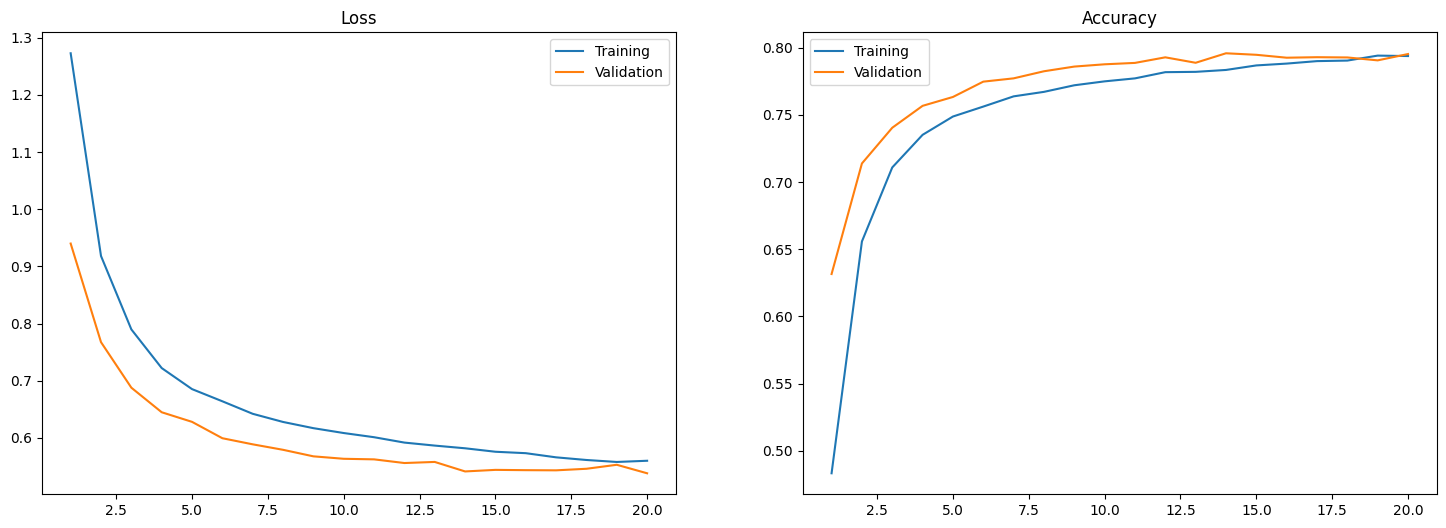

185/185 [==============================] - 2s 4ms/step - loss: 0.5671 - acc: 0.7808


In [83]:
dev_labels = lstm_codec.fit_transform(data_dev[H_LABELS])
rtl_model, rtl_X_dev = evaluate_direction(train_df, dev_df, dev_labels, aravec_model, lstm_codec, False, col=H_TOKENS)

#### Left to Right
<p>And now we reverse the sentences so they read left to right. Accuracy on the dev set is slightly lower than the Right to Left model at close to 31.7%.</p>

Epoch 1/20
664/664 [==============================] - 12s 13ms/step - loss: 1.3320 - acc: 0.4563 - val_loss: 0.9532 - val_acc: 0.6514
Epoch 2/20
664/664 [==============================] - 8s 12ms/step - loss: 0.9153 - acc: 0.6613 - val_loss: 0.7528 - val_acc: 0.7220
Epoch 3/20
664/664 [==============================] - 8s 12ms/step - loss: 0.7952 - acc: 0.7105 - val_loss: 0.6820 - val_acc: 0.7447
Epoch 4/20
664/664 [==============================] - 8s 11ms/step - loss: 0.7403 - acc: 0.7270 - val_loss: 0.6509 - val_acc: 0.7561
Epoch 5/20
664/664 [==============================] - 8s 12ms/step - loss: 0.7051 - acc: 0.7423 - val_loss: 0.6204 - val_acc: 0.7675
Epoch 6/20
664/664 [==============================] - 8s 12ms/step - loss: 0.6781 - acc: 0.7503 - val_loss: 0.6045 - val_acc: 0.7726
Epoch 7/20
664/664 [==============================] - 8s 12ms/step - loss: 0.6630 - acc: 0.7559 - val_loss: 0.5957 - val_acc: 0.7752
Epoch 8/20
664/664 [==============================] - 8s 12ms/step -

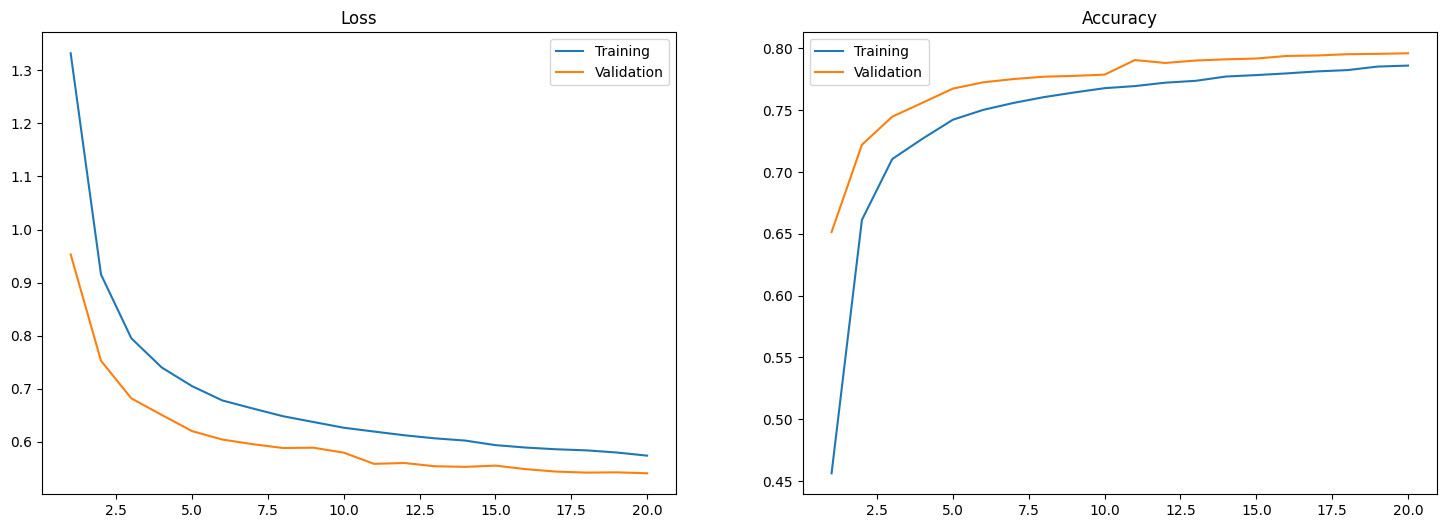

185/185 [==============================] - 2s 4ms/step - loss: 0.5780 - acc: 0.7823


In [85]:
ltr_model, ltr_X_dev = evaluate_direction(train_df, dev_df, dev_labels, aravec_model, lstm_codec, True, H_TOKENS)

## BERT for Dialectal Arabic

<p>Adapted from the <a href="https://www.tensorflow.org/official_models/fine_tuning_bert">Fine-tuning a BERT model</a> tutorial.</p>

In [86]:
def build_bert(num_classes, optimizer):
  '''
  Load up the BERT data and make a classifier with num_classes labels
  '''
  # Build the model
  bert_config_file = bert_dir + 'bert_config.json'
  config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
  bert_config = BertConfig.from_dict(config_dict)
  bert_classifier, bert_encoder = BertClassifier(bert_config, num_labels=num_classes)

  # Load the encoder weights
  checkpoint = tf.train.Checkpoint(model=bert_encoder)
  checkpoint.restore(bert_dir + 'bert_model.ckpt')

  # Compile
  bert_classifier.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                          metrics=[tf.keras.metrics.CategoricalAccuracy('acc', dtype=tf.float32)])

  return bert_classifier


def build_optimizer(num_samples, learning_rate, epochs, batch_size):
  '''
  Create a learning schedule based on size of dataset, batch size, and number of epochs
  Return the optimizer
  '''
  steps_per_epoch = int(num_samples / batch_size)
  train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * num_samples * 0.1 / batch_size)
  return create_optimizer(learning_rate, num_train_steps=train_steps, num_warmup_steps=warmup_steps)


def bertify(sentences, tokenizer):
  '''
  Convert the data into BERT inputs
  '''
  
  def encode(sentence):
    '''
    Helper function to tokenize a single sentence
    '''
    tokens = ['[CLS]'] + tokenizer.tokenize(sentence) + ['[SEP]']
    return tokenizer.convert_tokens_to_ids(tokens)

  # Token IDs
  input_word_ids = tf.ragged.constant([encode(sentence) for sentence in sentences])

  # Input mask
  input_mask = tf.ones_like(input_word_ids)

  # Input type IDs
  input_type_ids = tf.zeros_like(input_word_ids)

  # Input dict
  return {'input_word_ids': input_word_ids.to_tensor(),
          'input_mask': input_mask.to_tensor(),
          'input_type_ids': input_type_ids.to_tensor()}

### Prepare the data

In [87]:
# Corpus to use
df_train = c26_train
df_dev = c26_dev

# One hot encode the labels
bert_codec = OneHotCodec(df_train, df_dev)

# Split the train data into train/test
bert_X_train, bert_X_test, bert_y_train, bert_y_test = train_test_split(df_train.X, bert_codec.y_train,
                                                                        shuffle=True,
                                                                        test_size=0.2,
                                                                        random_state=23)

# Load the BERT tokenizer
bert_tokenizer = FullTokenizer(bert_dir + 'vocab.txt', do_lower_case=False)

# Build BERT inputs for train/test/dev
bert_X_train = bertify(bert_X_train, bert_tokenizer)
bert_X_test = bertify(bert_X_test, bert_tokenizer)
bert_X_dev = bertify(df_dev.X, bert_tokenizer)

NameError: name 'OneHotCodec' is not defined

<p>Here's the first training data entry. The <code>input_word_ids</code> are bookended by 101 and 102 (<code>[CLS]</code> and <code>[SEP]</code>, respectively)*, and then padded to the length of the longest sentence in the set. The <code>input_mask</code> tensor has a 1 where the <code>input_word_ids</code> contain a token, and a zero where it contains padding. The <code>input_type_ids</code> are all zeros, as there is only one sentence per training example.</p>

<p>*Because Arabic reads from right-to-left, here <code>[CLS]</code> technically occurs at the <i>end</i> of the sentence, and <code>[SEP]</code> at the <i>start</i>.</p>

In [ ]:
print(bert_X_train['input_word_ids'][0])
print(bert_X_train['input_mask'][0])
print(bert_X_train['input_type_ids'][0])

###<h3>Create the model</h3>
<p>We create an optimizer with a learning schedule based on the number of epochs, the batch size, and the size of the training set, and use it to help build the model. The accuracy before training is a little under 4%, as with the LSTM, which indicates random predictions.</p>
<p>
The <a href="https://arxiv.org/pdf/1810.04805.pdf">BERT paper</a> recommends the following options for fine-tuning:
<ul>
<li>Learning rate (Adam): 5e-5, 3e-5, 2e-5</li>
<li>Number of epochs: 2, 3, 4</li>
<li>Batch size: 16, 32</li>
</ul></p>

In [ ]:
# Set the training parameters
learning_rate = 2e-5
epochs = 4
batch_size = 32

# Create the optimizer and model
optimizer = build_optimizer(len(bert_y_train), learning_rate, epochs, batch_size)
bert_model = build_bert(bert_codec.num_classes, optimizer)

# Evaluate the untrained model
bert_model.evaluate(bert_X_dev, bert_codec.y_dev)

###<h3>Train the model</h3>
<p>After 4 epochs, validation accuracy is around 31%, and clearly levelling off, but accuracy on the dev set is 34%. This is a slight improvement over the LSTM.</p>

In [ ]:
# Train the model
bert_history = bert_model.fit(bert_X_train, bert_y_train,
                              validation_data=(bert_X_test, bert_y_test),
                              callbacks=[ClearOutputCallback()],
                              batch_size=batch_size,
                              epochs=epochs)

# Plot the results
plot_training(bert_history)

# Evaluate on the dev set
bert_model.evaluate(bert_X_dev, bert_codec.y_dev)

In [ ]:
# def grid_search(codec, X_dev, X_train, y_train, X_test, y_test, learning_rates, epochs, batch_sizes):
#   '''
#   Perform a grid search with the parameter lists
#   Return best params, model, and history
#   '''

#   best_acc = 0.0
#   best_params = None
#   best_model = None
#   best_history = None

#   for lr in learning_rates:
#     for e in epochs:
#       for bs in batch_sizes:
#         print(f'Learning rate: {lr}, Epochs: {e}, Batch size: {bs}')

#         # Create the optimizer and model
#         optimizer = build_optimizer(len(y_train), lr, e, bs)
#         model = build_bert(codec.num_classes, optimizer)

#         # Train the model
#         history = model.fit(X_train, y_train,
#                             validation_data=(X_test, y_test),
#                             # callbacks=[ClearOutputCallback()],
#                             batch_size=bs,
#                             epochs=e)

#         # Score the model
#         acc = model.evaluate(X_dev, codec.y_dev)[1]

#         # Update the best
#         if acc > best_acc:
#           best_acc = acc
#           best_params = [lr, e, bs]
#           best_model = model
#           best_history = history

#         # This is memory intensive, so best to deallocate manually for performance 
#         gc.collect()

#   return best_model, best_history, best_params


# Start the grid search
# bert_model, bert_history, bert_params = grid_search(bert_codec, bert_X_dev,
#                                                     bert_X_train, bert_y_train,
#                                                     bert_X_test, bert_y_test,
#                                                     learning_rates=[5e-5, 3e-5, 2e-5],
#                                                     epochs=[2, 3, 4],
#                                                     batch_sizes=[16, 32])

## ChatGPT

## Evaluation

<p>Here, the models built previously are used to make predictions which are then compared to the gold file with <code>MADAR-DID-Scorer.py</code>.</p>
<p>It's difficult to make a fair comparison as there are optimizations that could be done to each model. Unsurprisingly, however, it's evident that BERT outperforms the others with minimal tweaking.</p>
<p>The low, although not insignificant, predictive ability of the models is to be expected given such a large number of target classes, and scores of 70% to 80% were acheivable with the same models on MADAR-Corpus-06.</p>

###<h3>LSTM</h3>
<p>The right to left (natural order) model outperforms the left to  right slightly, but fails to outdo the character gram with word boundaries.</p>
<p>Fine tuning a model like this is non-trivial, but it could be made more efficient.</p>

####<h4>Right to Left</h4>

In [ ]:
evaluate_lstm_bert(rtl_model, lstm_codec, rtl_X_dev, c26_dev_gold)

####<h4>Left to Right</h4>

In [ ]:
evaluate_lstm_bert(ltr_model, lstm_codec, ltr_X_dev, c26_dev_gold)

###<h3>BERT</h3>
<p>The BERT model outperforms its rivals  after just 4 epochs of fine-tuning. With more compute resources and varying the pre-trained weights, improvements might be made.</p>

In [ ]:
evaluate_lstm_bert(bert_model, bert_codec, bert_X_dev, c26_dev_gold)